In [1]:
# Cell 1: Setup and Installs
!pip install sentence-transformers pandas scikit-learn tensorflow matplotlib

import pandas as pd
import numpy as np
import ast
import io
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# For reproducibility
tf.random.set_seed(42)
np.random.seed(42)

print("Libraries installed and imported.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 61.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
# Cell 2: Load Data from Colab Filesystem
import pandas as pd

# --- IMPORTANT: Ensure your CSV file is uploaded to Colab's file browser ---
file_path = '/content/English_long_formatted.csv'

try:
    df = pd.read_csv(file_path)
    print(f"Successfully loaded '{file_path}'")
except FileNotFoundError:
    print(f"ERROR: File not found at '{file_path}'. Please upload the file.")
    df = pd.DataFrame()

if not df.empty:
    if 'Unnamed: 0' in df.columns:
        df = df.drop(columns=['Unnamed: 0'])
    print("\nDataFrame Info:")
    df.info()
else:
    print("\nDataFrame is empty. Please check the file loading step.")

Successfully loaded '/content/English_long_formatted.csv'

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 582 entries, 0 to 581
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Scenario_id                 582 non-null    object
 1   Annotator_id                582 non-null    object
 2   Scenario                    582 non-null    object
 3   Possible_actions            582 non-null    object
 4   Selected_action             582 non-null    int64 
 5   Reason                      582 non-null    object
 6   Consequence                 581 non-null    object
 7   Action_criteria             582 non-null    object
 8   Contributing_factors        582 non-null    object
 9   Contributing_emotion        582 non-null    object
 10  Moral_values                582 non-null    object
 11  Cultural_values             582 non-null    object
 12  Annotator_self_description  582

In [3]:
# Cell 3: Full Feature Engineering and Input Preparation

def safe_literal_eval(val):
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError, TypeError):
        return val

# Proceed only if the DataFrame is loaded
if not df.empty:
    # --- Parse all dictionary and list-like columns ---
    df['Possible_actions'] = df['Possible_actions'].apply(safe_literal_eval)
    df['Contributing_factors'] = df['Contributing_factors'].apply(safe_literal_eval)
    df['Contributing_emotion'] = df['Contributing_emotion'].apply(safe_literal_eval)
    df['Moral_values_dict'] = df['Moral_values'].apply(safe_literal_eval)
    df['Cultural_values_dict'] = df['Cultural_values'].apply(safe_literal_eval)

    # --- Prepare Textual Input Features ---
    # Create 'Selected_action_text'
    df['Selected_action_text'] = df.apply(
        lambda row: row['Possible_actions'][row['Selected_action'] - 1] if isinstance(row['Possible_actions'], list) and 0 <= row['Selected_action'] - 1 < len(row['Possible_actions']) else "",
        axis=1
    )
    # Convert list features to single strings
    def list_to_string(val_list):
        return ", ".join(map(str, val_list)) if isinstance(val_list, list) else str(val_list)

    df['Contributing_factors_text'] = df['Contributing_factors'].apply(list_to_string)
    df['Contributing_emotion_text'] = df['Contributing_emotion'].apply(list_to_string)

    text_feature_cols = [
        'Scenario', 'Selected_action_text', 'Reason', 'Consequence',
        'Contributing_factors_text', 'Contributing_emotion_text', 'Annotator_self_description'
    ]
    for col in text_feature_cols:
        df[col] = df[col].fillna("").astype(str)

    # --- Prepare Numerical Input Features ---
    # Basic numerical feature
    numerical_feature_cols = ['Selected_action']
    df[numerical_feature_cols] = df[numerical_feature_cols].astype(float)

    # Moral values
    moral_value_keys = ['Care', 'Equality', 'Proportionality', 'Loyalty', 'Authority', 'Purity']
    moral_feature_cols = [f'moral_{key}' for key in moral_value_keys]
    for key, col_name in zip(moral_value_keys, moral_feature_cols):
        df[col_name] = df['Moral_values_dict'].apply(lambda x: x.get(key, np.nan) if isinstance(x, dict) else np.nan)

    # Cultural values
    cultural_value_keys = ['Power Distance', 'Individualism', 'Masculinity', 'Uncertainty Avoidance', 'Long Term Orientation', 'Indulgence vs Restraint']
    cultural_feature_cols = [f'cultural_{key.replace(" ", "_")}' for key in cultural_value_keys]
    for key, col_name in zip(cultural_value_keys, cultural_feature_cols):
        df[col_name] = df['Cultural_values_dict'].apply(lambda x: x.get(key, np.nan) if isinstance(x, dict) else np.nan)

    all_numerical_inputs = numerical_feature_cols + moral_feature_cols + cultural_feature_cols
    print(f"\nAll numerical input columns ({len(all_numerical_inputs)}): {all_numerical_inputs}")

    # Drop rows where any of these numerical inputs are missing
    df.dropna(subset=all_numerical_inputs, inplace=True)
    print(f"\nShape after ensuring all numerical inputs are present: {df.shape}")
else:
    print("DataFrame empty, skipping feature engineering.")


All numerical input columns (13): ['Selected_action', 'moral_Care', 'moral_Equality', 'moral_Proportionality', 'moral_Loyalty', 'moral_Authority', 'moral_Purity', 'cultural_Power_Distance', 'cultural_Individualism', 'cultural_Masculinity', 'cultural_Uncertainty_Avoidance', 'cultural_Long_Term_Orientation', 'cultural_Indulgence_vs_Restraint']

Shape after ensuring all numerical inputs are present: (582, 30)


In [4]:
# Cell 4: Target Variable Preparation (Action_criteria)

if not df.empty:
    # --- Parse, Validate, and Clean the Target Column ---
    def parse_criteria(criteria_str):
        try:
            # Evaluate the string to a list
            criteria_list = ast.literal_eval(criteria_str)
            # Ensure it's a list of 4 numbers
            if isinstance(criteria_list, list) and len(criteria_list) == 4:
                return [float(x) for x in criteria_list] # Convert to float for regression
            return np.nan # Invalid format
        except:
            return np.nan # Parsing error

    df['Action_criteria_parsed'] = df['Action_criteria'].apply(parse_criteria)
    df.dropna(subset=['Action_criteria_parsed'], inplace=True) # Drop rows with invalid target data

    # --- Create the final y_target array ---
    ethical_principle_cols = ['Deontology', 'Utilitarianism', 'Rights_based', 'Virtue']
    y_targets = np.array(df['Action_criteria_parsed'].tolist())

    print("Target variable 'Action_criteria' processed.")
    print(f"Shape of target array y_targets: {y_targets.shape}")
    print(f"Final DataFrame shape after target cleaning: {df.shape}")
    print("\nExample of a processed target row:")
    print(y_targets[0])
else:
    print("DataFrame empty, skipping target variable prep.")

Target variable 'Action_criteria' processed.
Shape of target array y_targets: (582, 4)
Final DataFrame shape after target cleaning: (582, 31)

Example of a processed target row:
[2. 4. 4. 5.]


In [5]:
# Cell 5: Generate Text Embeddings
embedding_model_name = 'all-MiniLM-L6-v2'

if not df.empty:
    sbert_model = SentenceTransformer(embedding_model_name)
    print(f"Sentence Transformer model '{embedding_model_name}' loaded.")

    embeddings_list = []
    for col in text_feature_cols:
        print(f"Generating embeddings for: {col}")
        texts_to_embed = df[col].tolist()
        embeddings = sbert_model.encode(texts_to_embed, show_progress_bar=True)
        embeddings_list.append(embeddings)

    X_text_embeddings = np.concatenate(embeddings_list, axis=1)
    print(f"\nShape of concatenated text embeddings: {X_text_embeddings.shape}")
else:
    X_text_embeddings = np.array([])
    print("DataFrame empty, skipping embedding generation.")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Sentence Transformer model 'all-MiniLM-L6-v2' loaded.
Generating embeddings for: Scenario


Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Generating embeddings for: Selected_action_text


Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Generating embeddings for: Reason


Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Generating embeddings for: Consequence


Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Generating embeddings for: Contributing_factors_text


Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Generating embeddings for: Contributing_emotion_text


Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Generating embeddings for: Annotator_self_description


Batches:   0%|          | 0/19 [00:00<?, ?it/s]


Shape of concatenated text embeddings: (582, 2688)


In [6]:
# Cell 6: Final Feature Scaling and Data Preparation

if not df.empty:
    # --- Scale all numerical features ---
    X_numerical_features_raw = df[all_numerical_inputs].values
    scaler_numerical = StandardScaler()
    X_numerical_scaled = scaler_numerical.fit_transform(X_numerical_features_raw)
    print(f"Shape of scaled numerical features: {X_numerical_scaled.shape}")

    # --- Concatenate all features to create the final X array ---
    X_final_features = np.concatenate([X_text_embeddings, X_numerical_scaled], axis=1)

    print(f"\nFinal shape of X_final_features: {X_final_features.shape}")
    print(f"Final shape of y_targets: {y_targets.shape}")
else:
    print("DataFrame empty, skipping final data prep.")

Shape of scaled numerical features: (582, 13)

Final shape of X_final_features: (582, 2701)
Final shape of y_targets: (582, 4)


In [7]:
# Cell 7: Split Data into Training and Testing Sets

if not df.empty:
    X_train, X_test, y_train, y_test = train_test_split(
        X_final_features, y_targets, test_size=0.2, random_state=42
    )
    print("Data successfully split into training and testing sets.")
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
else:
    print("DataFrame empty, skipping train-test split.")

Data successfully split into training and testing sets.
X_train shape: (465, 2701), y_train shape: (465, 4)
X_test shape: (117, 2701), y_test shape: (117, 4)


In [8]:
# Cell 8: Build and Compile the Multi-Output Regression Model

if not df.empty:
    input_dims = X_train.shape[1]
    output_dims = len(ethical_principle_cols) # Should be 4

    input_layer = Input(shape=(input_dims,), name='input_layer')

    # Shared layers
    x = Dense(256, activation='relu', name='dense_1')(input_layer)
    x = Dropout(0.4, name='dropout_1')(x)
    x = Dense(128, activation='relu', name='dense_2')(x)
    x = Dropout(0.4, name='dropout_2')(x)

    # Output layer for regression
    output_layer = Dense(output_dims, activation='linear', name='ethical_principles_output')(x)

    model = Model(inputs=input_layer, outputs=output_layer, name="Ethical_Principles_Model")

    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae']) # Mean Absolute Error is easy to interpret

    model.summary()
else:
    print("DataFrame empty, skipping model build.")

Model: "Ethical_Principles_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2701)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       691,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ ethical_principles_output       │ (None, 4)              │           516 │
│ (Dense)                         │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 725,124 (2.77 MB)

 Trainable params: 725,124 (2.77 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Cell 9: Train the Model

if not df.empty and 'model' in locals():
    epochs = 150
    batch_size = 32

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=20, # Give it more time to converge
        restore_best_weights=True,
        verbose=1
    )

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
        verbose=1
    )

    print("\nModel training finished.")
else:
    print("Skipping model training.")

Epoch 1/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 13.0143 - mae: 3.3368 - val_loss: 5.5295 - val_mae: 2.0340
Epoch 2/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.2211 - mae: 1.7331 - val_loss: 2.1210 - val_mae: 1.1759
Epoch 3/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 2.9946 - mae: 1.3929 - val_loss: 1.8211 - val_mae: 1.1933
Epoch 4/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.1942 - mae: 1.2079 - val_loss: 1.5375 - val_mae: 1.0529
Epoch 5/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.0301 - mae: 1.1610 - val_loss: 1.4947 - val_mae: 1.0520
Epoch 6/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.9562 - mae: 1.1371 - val_loss: 1.4318 - val_mae: 1.0225
Epoch 7/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.8649 - mae: 1.1191 - val_loss: 1.3916 - val_mae: 1.0004
Epoch 8/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.7836 - mae: 1.0566 - val_loss: 1.3598 - val_mae: 0.9813
Epoch 9/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - l

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

--- Model Evaluation ---

1. Regression Metrics (on original float predictions):
  Overall MSE: 1.2561
  Overall R² Score: 0.2265

  Per-Principle MSE:
    Deontology: 1.5691
    Utilitarianism: 1.1879
    Rights_based: 1.3647
    Virtue: 0.9029

2. Classification-style Metrics (on rounded & clipped predictions):
  Exact Match Ratio (all 4 ratings correct): 0.0342

  Per-Principle Accuracy:
    Deontology: 0.2650
    Utilitarianism: 0.3162
    Rights_based: 0.3419
    Virtue: 0.4615

  Classification Report for 'Deontology':
              precision    recall  f1-score   support

           1       0.62      0.20      0.30        25
           2       0.23      0.47      0.31        19
           3       0.19      0.29      0.23        24
           4       0.20      0.21      0.20        24
           5       0.62      0.20      0.30        25

    accuracy                           0.26       117
   macro avg       0.37      0.27      0.27       

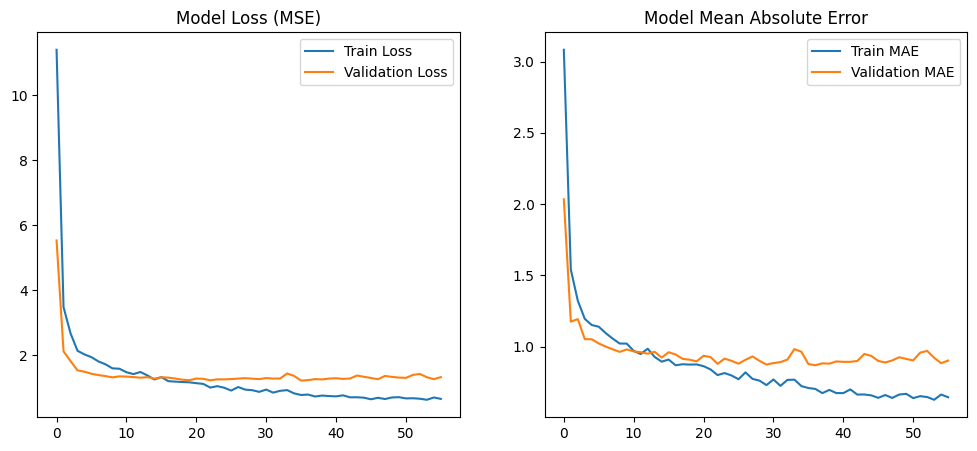

In [10]:
# Cell 10: Evaluate the Model

if not df.empty and 'model' in locals():
    # --- Make Predictions ---
    y_pred_float = model.predict(X_test)

    # Round predictions to nearest integer and clip to the Likert scale [1, 5]
    y_pred_rounded = np.round(y_pred_float).astype(int)
    y_pred_clipped = np.clip(y_pred_rounded, 1, 5)

    print("\n--- Model Evaluation ---")

    # --- Regression Metrics (on float predictions) ---
    print("\n1. Regression Metrics (on original float predictions):")
    overall_mse = mean_squared_error(y_test, y_pred_float)
    overall_r2 = r2_score(y_test, y_pred_float)
    print(f"  Overall MSE: {overall_mse:.4f}")
    print(f"  Overall R² Score: {overall_r2:.4f}")
    print("\n  Per-Principle MSE:")
    for i, name in enumerate(ethical_principle_cols):
        mse = mean_squared_error(y_test[:, i], y_pred_float[:, i])
        print(f"    {name}: {mse:.4f}")

    # --- Classification-style Metrics (on rounded & clipped predictions) ---
    print("\n2. Classification-style Metrics (on rounded & clipped predictions):")
    exact_match_ratio = np.all(y_pred_clipped == y_test.astype(int), axis=1).mean()
    print(f"  Exact Match Ratio (all 4 ratings correct): {exact_match_ratio:.4f}")

    print("\n  Per-Principle Accuracy:")
    for i, name in enumerate(ethical_principle_cols):
        acc = accuracy_score(y_test[:, i].astype(int), y_pred_clipped[:, i])
        print(f"    {name}: {acc:.4f}")

    print("\n  Classification Report for 'Deontology':")
    print(classification_report(y_test[:, 0].astype(int), y_pred_clipped[:, 0]))

    # --- Plot Training History ---
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss (MSE)')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Model Mean Absolute Error')
    plt.legend()
    plt.show()

else:
    print("Skipping model evaluation.")

In [11]:
# Cell 11: Example Prediction

if not df.empty and 'model' in locals():
    sample_index = 10 # You can change this index to see different predictions

    # Select the sample and predict
    sample_X = X_test[sample_index:sample_index+1]
    sample_y_actual = y_test[sample_index]
    sample_y_pred_float = model.predict(sample_X)[0]

    # Round and clip the prediction
    sample_y_pred_clipped = np.clip(np.round(sample_y_pred_float), 1, 5).astype(int)

    print("\n--- Example Prediction ---")
    print(f"Showing sample #{sample_index} from the test set.\n")

    print("Ethical Principles:")
    print("-------------------")
    for i, name in enumerate(ethical_principle_cols):
        print(f"  {name+':':<16} Actual: {int(sample_y_actual[i])},  Predicted: {sample_y_pred_clipped[i]}")

    print("\nFormatted Output:")
    print(f"  Actual: {list(sample_y_actual.astype(int))}")
    print(f"  Predicted: {list(sample_y_pred_clipped)}")

else:
    print("Skipping example prediction.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

--- Example Prediction ---
Showing sample #10 from the test set.

Ethical Principles:
-------------------
  Deontology:      Actual: 5,  Predicted: 5
  Utilitarianism:  Actual: 5,  Predicted: 4
  Rights_based:    Actual: 5,  Predicted: 5
  Virtue:          Actual: 5,  Predicted: 4

Formatted Output:
  Actual: [np.int64(5), np.int64(5), np.int64(5), np.int64(5)]
  Predicted: [np.int64(5), np.int64(4), np.int64(5), np.int64(4)]


## Model 2

In [12]:
# Cell 12: Target Variable Preparation (Contributing_factors)

if not df.empty:
    # --- Parse, Validate, and Clean the Target Column for Contributing Factors ---
    def parse_factors(factors_str):
        try:
            # The data is already a list of numbers from Cell 3's parsing
            factors_list = safe_literal_eval(factors_str)
            # Ensure it's a list of 8 numbers
            if isinstance(factors_list, list) and len(factors_list) == 8:
                return [float(x) for x in factors_list]
            return np.nan
        except:
            return np.nan

    df['Factors_parsed'] = df['Contributing_factors'].apply(parse_factors)

    # Drop rows where parsing failed for this new target
    df.dropna(subset=['Factors_parsed'], inplace=True)

    # --- Create the new y_target array ---
    # NOTE: We are overwriting the previous y_targets. We've already used it.
    y_factors_targets = np.array(df['Factors_parsed'].tolist())

    # Also realign X_final_features to match the potentially smaller df
    X_final_features_factors = X_final_features[df.index]

    contributing_factor_cols = [
        'Emotions', 'Moral', 'Culture', 'Responsibilities',
        'Relationships', 'Legality', 'Politeness', 'Sacred_values'
    ]

    print("\nTarget variable 'Contributing_factors' processed.")
    print(f"Shape of target array y_factors_targets: {y_factors_targets.shape}")
    print(f"Shape of input array X_final_features_factors: {X_final_features_factors.shape}")

else:
    print("DataFrame empty, skipping target variable prep for factors.")


Target variable 'Contributing_factors' processed.
Shape of target array y_factors_targets: (582, 8)
Shape of input array X_final_features_factors: (582, 2701)


In [13]:
# Cell 13: Split Data for Contributing Factors Model

if not df.empty:
    X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(
        X_final_features_factors, y_factors_targets, test_size=0.2, random_state=42
    )
    print("Data successfully split for Contributing Factors model.")
    print(f"X_train_f shape: {X_train_f.shape}, y_train_f shape: {y_train_f.shape}")
    print(f"X_test_f shape: {X_test_f.shape}, y_test_f shape: {y_test_f.shape}")
else:
    print("DataFrame empty, skipping train-test split for factors model.")

Data successfully split for Contributing Factors model.
X_train_f shape: (465, 2701), y_train_f shape: (465, 8)
X_test_f shape: (117, 2701), y_test_f shape: (117, 8)


In [14]:
# Cell 14: Build and Compile the Contributing Factors Model

if not df.empty:
    input_dims_f = X_train_f.shape[1]
    output_dims_f = len(contributing_factor_cols) # Should be 8

    input_layer_f = Input(shape=(input_dims_f,), name='input_layer_factors')

    # Using a slightly different architecture to show flexibility
    x = Dense(384, activation='relu', name='dense_1_factors')(input_layer_f)
    x = Dropout(0.5, name='dropout_1_factors')(x)
    x = Dense(192, activation='relu', name='dense_2_factors')(x)
    x = Dropout(0.5, name='dropout_2_factors')(x)

    # Output layer for the 8 regression targets
    output_layer_f = Dense(output_dims_f, activation='linear', name='factors_output')(x)

    model_factors = Model(inputs=input_layer_f, outputs=output_layer_f, name="Contributing_Factors_Model")

    optimizer_f = Adam(learning_rate=0.0007)
    model_factors.compile(optimizer=optimizer_f, loss='mean_squared_error', metrics=['mae'])

    model_factors.summary()
else:
    print("DataFrame empty, skipping factors model build.")

Model: "Contributing_Factors_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_factors             │ (None, 2701)           │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1_factors (Dense)         │ (None, 384)            │     1,037,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1_factors (Dropout)     │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2_factors (Dense)         │ (None, 192)            │        73,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2_factors (Dropout)     │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ factors_output (Dense)          │ (None, 8)              │         1,544 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,113,032 (4.25 MB)

 Trainable params: 1,113,032 (4.25 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Cell 15: Train the Contributing Factors Model

if not df.empty and 'model_factors' in locals():
    epochs_f = 150
    batch_size_f = 32

    early_stopping_f = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=25, # A bit more patience
        restore_best_weights=True,
        verbose=1
    )

    history_f = model_factors.fit(
        X_train_f, y_train_f,
        epochs=epochs_f,
        batch_size=batch_size_f,
        validation_split=0.15,
        callbacks=[early_stopping_f],
        verbose=1
    )

    print("\nContributing Factors model training finished.")
else:
    print("Skipping factors model training.")

Epoch 1/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 8.9734 - mae: 2.5938 - val_loss: 2.0034 - val_mae: 1.2085
Epoch 2/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.2191 - mae: 1.4741 - val_loss: 2.1191 - val_mae: 1.1725
Epoch 3/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2.4931 - mae: 1.2771 - val_loss: 1.4884 - val_mae: 1.0259
Epoch 4/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 2.2877 - mae: 1.2197 - val_loss: 1.5184 - val_mae: 1.0213
Epoch 5/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 1.9542 - mae: 1.1231 - val_loss: 1.2735 - val_mae: 0.9386
Epoch 6/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.8385 - mae: 1.0923 - val_loss: 1.2018 - val_mae: 0.9050
Epoch 7/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 1.7051 - mae: 1.0381 - val_loss: 1.2725 - val_mae: 0.9387
Epoch 8/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 1.6399 - mae: 1.0212 - val_loss: 1.1864 - val_mae: 0.9081
Epoch 9/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - lo

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

--- Contributing Factors Model Evaluation ---

1. Regression Metrics (on float predictions):
  Overall MSE: 0.8970
  Overall R² Score: 0.4556

2. Classification-style Metrics (on rounded & clipped predictions):
  Exact Match Ratio (all 8 ratings correct): 0.0000

  Per-Factor Accuracy:
    Emotions         : 0.4530
    Moral            : 0.4359
    Culture          : 0.4274
    Responsibilities : 0.3162
    Relationships    : 0.3761
    Legality         : 0.3846
    Politeness       : 0.3846
    Sacred_values    : 0.3932


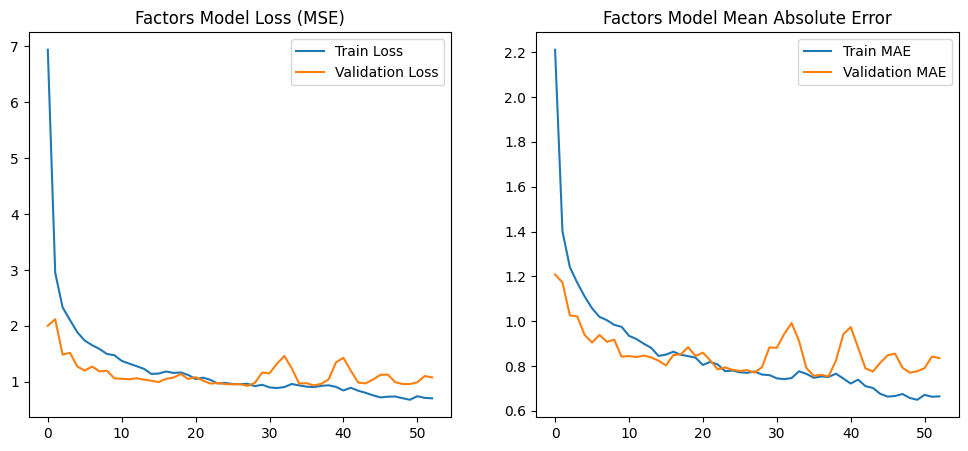

In [16]:
# Cell 16: Evaluate the Contributing Factors Model

if not df.empty and 'model_factors' in locals():
    # --- Make Predictions ---
    y_pred_float_f = model_factors.predict(X_test_f)
    y_pred_clipped_f = np.clip(np.round(y_pred_float_f), 1, 5).astype(int)

    print("\n--- Contributing Factors Model Evaluation ---")

    # --- Regression Metrics ---
    print("\n1. Regression Metrics (on float predictions):")
    overall_mse_f = mean_squared_error(y_test_f, y_pred_float_f)
    overall_r2_f = r2_score(y_test_f, y_pred_float_f)
    print(f"  Overall MSE: {overall_mse_f:.4f}")
    print(f"  Overall R² Score: {overall_r2_f:.4f}")

    # --- Classification-style Metrics ---
    print("\n2. Classification-style Metrics (on rounded & clipped predictions):")
    exact_match_ratio_f = np.all(y_pred_clipped_f == y_test_f.astype(int), axis=1).mean()
    print(f"  Exact Match Ratio (all 8 ratings correct): {exact_match_ratio_f:.4f}")

    print("\n  Per-Factor Accuracy:")
    for i, name in enumerate(contributing_factor_cols):
        acc = accuracy_score(y_test_f[:, i].astype(int), y_pred_clipped_f[:, i])
        print(f"    {name:<17}: {acc:.4f}")

    # --- Plot Training History ---
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history_f.history['loss'], label='Train Loss')
    plt.plot(history_f.history['val_loss'], label='Validation Loss')
    plt.title('Factors Model Loss (MSE)')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history_f.history['mae'], label='Train MAE')
    plt.plot(history_f.history['val_mae'], label='Validation MAE')
    plt.title('Factors Model Mean Absolute Error')
    plt.legend()
    plt.show()

else:
    print("Skipping factors model evaluation.")

In [17]:
# Cell 17: Example Prediction for Contributing Factors

if not df.empty and 'model_factors' in locals():
    sample_index_f = 5 # Using a different index for variety

    sample_X_f = X_test_f[sample_index_f:sample_index_f+1]
    sample_y_actual_f = y_test_f[sample_index_f]
    sample_y_pred_float_f = model_factors.predict(sample_X_f)[0]
    sample_y_pred_clipped_f = np.clip(np.round(sample_y_pred_float_f), 1, 5).astype(int)

    print("\n--- Example Prediction (Contributing Factors) ---")
    print(f"Showing sample #{sample_index_f} from the test set.\n")

    print("Contributing Factors:")
    print("---------------------")
    for i, name in enumerate(contributing_factor_cols):
        print(f"  {name+':':<17} Actual: {int(sample_y_actual_f[i])},  Predicted: {sample_y_pred_clipped_f[i]}")

    print("\nFormatted Output:")
    print(f"  Actual:    {list(sample_y_actual_f.astype(int))}")
    print(f"  Predicted: {list(sample_y_pred_clipped_f)}")

else:
    print("Skipping factors example prediction.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step

--- Example Prediction (Contributing Factors) ---
Showing sample #5 from the test set.

Contributing Factors:
---------------------
  Emotions:         Actual: 4,  Predicted: 4
  Moral:            Actual: 3,  Predicted: 4
  Culture:          Actual: 2,  Predicted: 3
  Responsibilities: Actual: 2,  Predicted: 3
  Relationships:    Actual: 4,  Predicted: 4
  Legality:         Actual: 3,  Predicted: 2
  Politeness:       Actual: 3,  Predicted: 4
  Sacred_values:    Actual: 3,  Predicted: 3

Formatted Output:
  Actual:    [np.int64(4), np.int64(3), np.int64(2), np.int64(2), np.int64(4), np.int64(3), np.int64(3), np.int64(3)]
  Predicted: [np.int64(4), np.int64(4), np.int64(3), np.int64(3), np.int64(4), np.int64(2), np.int64(4), np.int64(3)]
